In [144]:
import deepmini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

In [145]:
mpsc = deepmini.MPSC(num_data=100)

In [146]:
def visualize_mpsc(i):
    plt.plot(mpsc.params[i]['x'], mpsc.params[i]['y'], 'k')
    for q in range(len(mpsc.targets[i])):
        plt.plot(mpsc.targets[i][q][0], mpsc.targets[i][q][1], 'bx')
        plt.plot(mpsc.targets[i][q][2], mpsc.targets[i][q][3], 'rx')

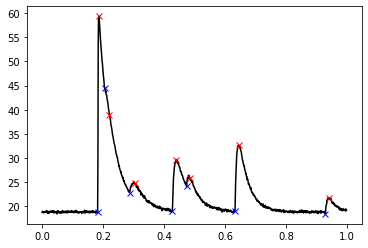

In [147]:
visualize_mpsc(3)

In [78]:
x0 = mpsc.params[3]['y'].view([1,1,1000])
x0.size()

torch.Size([1, 1, 1000])

In [80]:
class BaseBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channel, out_channel, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channel, out_channel, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channel)
        
    def forward(self,x):
        residual = x
        
        #first part
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        #second part with residual
        out = self.conv2(out)
        out = self.bn2(out)
        
        print(out.size(), residual.size())
        out += residual
        out = self.relu(out)
        
        return out
    
    
class ResNet1d(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride =2, padding=1)
        
        self.block1 = BaseBlock(64, 64)
        self.block2 = BaseBlock(64, 128)
        self.block3 = BaseBlock(128, 256)
        
        
        
    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.block1(out)  # 원한다면 여기서 더 추가해줘도 괜찮음
        out = self.block2(out)
        out = self.block3(out)
        return out



In [82]:
ResNet1d()

ResNet1d(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): BaseBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): BaseBlock(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1

# 다운 샘플링 하는 방법 
: residual network에서 residual & output의 채널 디멘션이 안 맞는 경우를 대비해야함.

따라서 basic block은 input channel = output channel로 만들고, 그 사이에 conv layer을 한번 더 끼워서 채널을 맞춰주면 될 것 같음. 이때, 텐서의 형태 자체는 동일해야하므로 이미지의 손실이 일어나서는 안된다. 찾아보니까 여러가지를 사용하던데 

1) https://github.com/jhcha08/Implementation_DeepLearningPaper/blob/master/%EC%8A%A4%ED%84%B0%EB%94%94%2020200129%20-%20CNN.%20ResNet.ipynb

: basic block을 쓰고 채널이 바뀌면 그 사이에 conv2d(3x3, padding=1) 레이어를 하나 더 넣어서 채널을 맞춰주려는 것 같다. 사실 가장 기초적이고 코드도 이해하기 제일 쉬움.

2)https://github.com/geekfeiw/Multi-Scale-1D-ResNet/blob/master/test.py

: 1d network라서 참고를 많이 하려고 했는데, 이 경우는 3,5,7 필터를 모두 써서 마지막에 싹다 더해버리는, 변형된 구조의 resnet이다. 일단 이 친구 구조가 어떻게 된건지 이해는 가는데 다운샘플링하는 코드가 영 이해가 안가서 일단은 1번을 따라가면서 다운샘플링까지 되어서 '굴러가는' ResNet을 만들어보고 그 다음에 여기 코드에서 사용한 '여러가지 필터 사용 후 더하기'를 고려해봐야할 듯.

: 한 가지 더 특이한 점은, 여기에서는 이미지 크기 자체가 1x512에서 점차 작아지도록 컨볼루션 레이어를 짰다는 것. 아마도 필터 크기를 다양하게 하려고 한게 아닐까 싶기도 한데 진짜 잘 모르겠다. 1부터 마스터하고 생각하자.

3) https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L39-L51

: 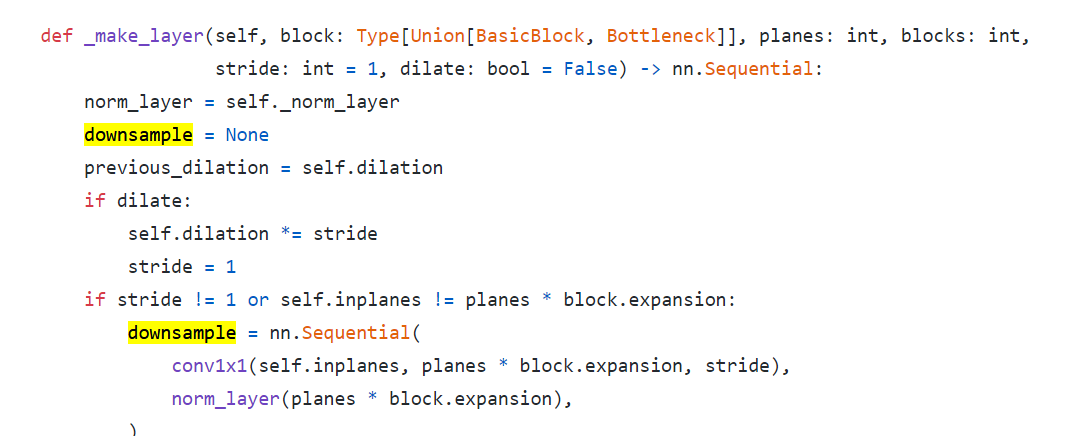

: official한 pytorch 깃허브에 올라와있는 ResNet 소스코드. 자세히 보면 downsample 부분에 1x1 필터를 쓰는 conv 레이어를 끼워놓은 게 보임. 여기가 중요한 부분인것 같은데, downsample을 시키는 조건(stride != 1, ....) 그 부분이 이해가 잘 안간다. 이후에 batch norm도 한번 실시했네용.....

## 1d ResNet
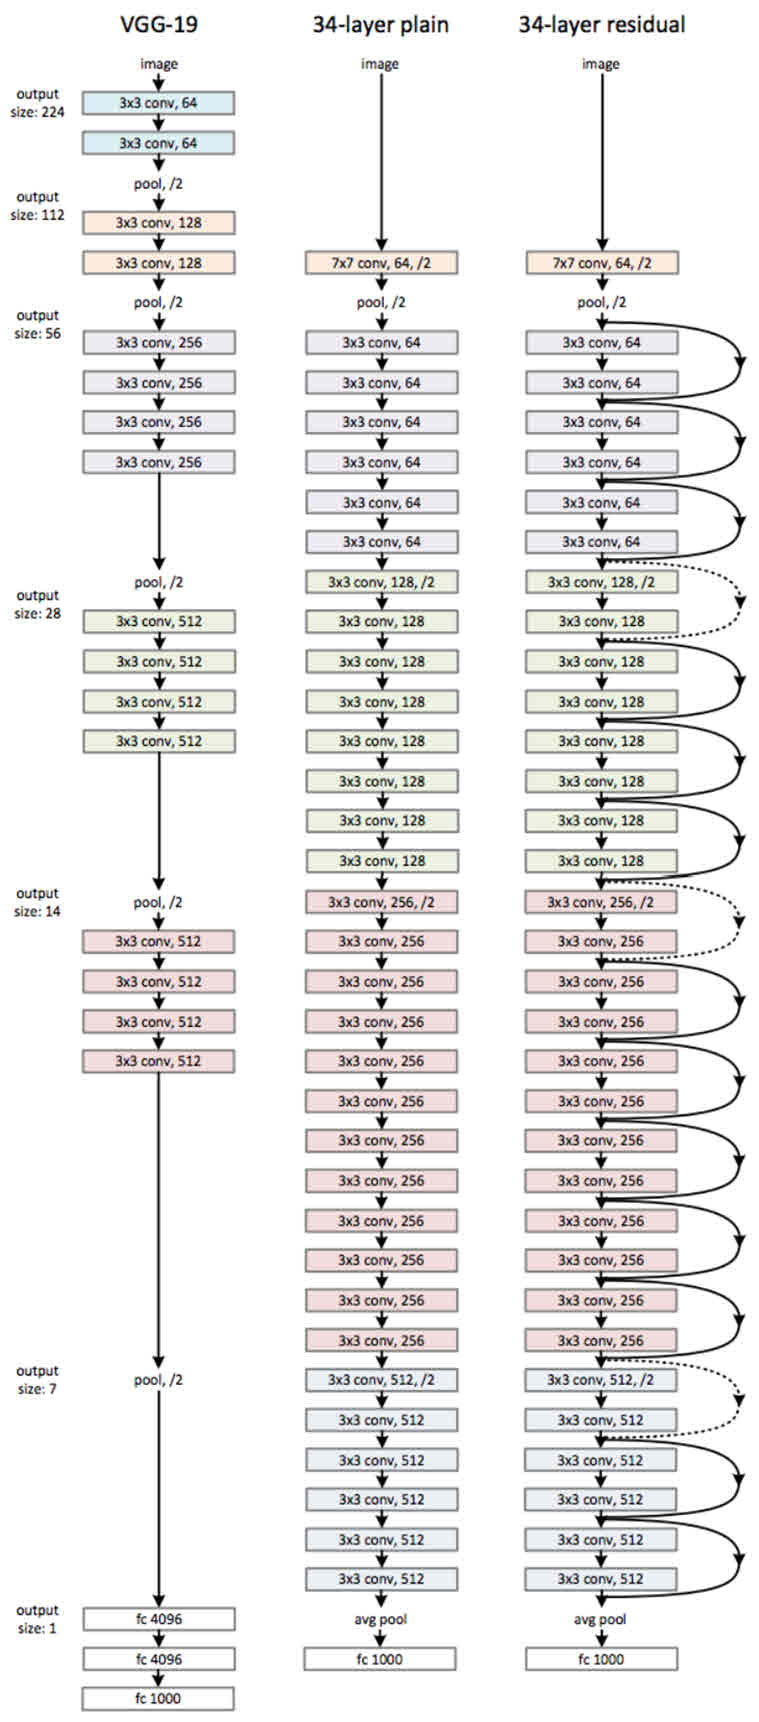

In [139]:
class BaseBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        self.in_ch = in_channel
        self.out_ch = out_channel 
        
        self.conv1 = nn.Conv1d(self.in_ch, self.out_ch, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv1d(self.in_ch, self.out_ch, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(self.out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(self.out_ch, self.out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(self.out_ch)
        
    def forward(self,x):
        residual = x
        
        # first part
        if self.in_ch == self.out_ch:
            out = self.conv1(x)
       
            out = self.bn1(out)
            out = self.relu(out)

            # second part with residual
            out = self.conv2(out)
            out = self.bn2(out)

            out += residual
            out = self.relu(out)
        
        else :
            out = self.conv1_2(x)  # n_channel: 2배, feature map size: 1/2배
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)
        
        return out
    
    
class ResNet1d(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride =2, padding=1)
        
        # 레이어는 임의로 2개씩 쌓아봄. (원래 ResNet과는 상이함)
        self.block1 = BaseBlock(64, 64) 
        self.block2 = BaseBlock(64, 64)
    
        self.block3 = BaseBlock(64, 128)
        self.block4 = BaseBlock(128, 128)

        self.block5 = BaseBlock(128, 256)
        self.block6 = BaseBlock(256, 256)
        
        self.block7 = BaseBlock(256, 512)
        self.block8 = BaseBlock(512, 512)     # 여기까지 했을 때 outputs.size() = [1,512,32] -> [1,512,1]로 만들어야함
        
        self.avgpool = nn.AvgPool1d(kernel_size=32, stride=1, padding=0)
        self.fc = nn.Linear(512, 1) # 1 부분은 언제라도 바꿀 수 있음 (num_classes)
        

    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.block1(out) 
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out)
        
        out = self.avgpool(out)
        
        out = out.squeeze()
        out = self.fc(out)
        
        return out

In [140]:
model = ResNet1d()

In [141]:
x0.size()

torch.Size([1, 1, 1000])

In [142]:
outputs = model(x0)

In [143]:
outputs.size()

torch.Size([1])